In [3]:
!python --version

Python 3.12.4


In [4]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from dateutil import parser
from datetime import datetime


pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 500)

import warnings
warnings.filterwarnings("ignore")

from sklearn.cluster import Birch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture
from sklearn.cluster import SpectralClustering, AgglomerativeClustering, KMeans
from kmodes.kprototypes import KPrototypes

from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

#from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import cross_val_score ,StratifiedKFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler, StandardScaler

le = LabelEncoder()
skf10 = StratifiedKFold(n_splits=10, shuffle=True,random_state=24)
skf5 = StratifiedKFold(n_splits=5, shuffle=True,random_state=24)

from lofo import LOFOImportance, Dataset, plot_importance
from sklearn.feature_selection import RFECV
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

import optuna
from scipy.stats import mode
from itertools import combinations
from tqdm.notebook import tqdm
tqdm.pandas()

import unicodedata


# 1. Veriye İlk Bakış

In [5]:
test       = pd.read_csv('data\\test_x.csv').drop(['id'],axis=1)
train      = pd.read_csv('data\\train.csv').drop(['id'],axis=1)
train_copy = pd.read_csv('data\\train.csv').drop(['id'],axis=1)

target_col = 'Degerlendirme Puani'
categoric_cols = [col for col in train.columns if train[col].dtype == 'O']
numeric_cols = [col for col in train.columns if train[col].dtype != 'O']
numeric_cols.remove(target_col)

In [6]:
train

,Basvuru Yili,Degerlendirme Puani,Cinsiyet,Dogum Tarihi,Dogum Yeri,Ikametgah Sehri,Universite Adi,Universite Turu,Burslu ise Burs Yuzdesi,Burs Aliyor mu?,Bölüm,Universite Kacinci Sinif,Universite Not Ortalamasi,Daha Once Baska Bir Universiteden Mezun Olmus,Lise Adi,Lise Adi Diger,Lise Sehir,Lise Turu,Lise Bolumu,Lise Bolum Diger,Lise Mezuniyet Notu,Baska Bir Kurumdan Burs Aliyor mu?,Burs Aldigi Baska Kurum,Baska Kurumdan Aldigi Burs Miktari,Anne Egitim Durumu,Anne Calisma Durumu,Anne Sektor,Baba Egitim Durumu,Baba Calisma Durumu,Baba Sektor,Kardes Sayisi,Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?,Uye Oldugunuz Kulubun Ismi,Profesyonel Bir Spor Daliyla Mesgul musunuz?,Spor Dalindaki Rolunuz Nedir?,Aktif olarak bir STK üyesi misiniz?,Hangi STK'nin Uyesisiniz?,Stk Projesine Katildiniz Mi?,Girisimcilikle Ilgili Deneyiminiz Var Mi?,Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?,Ingilizce Biliyor musunuz?,Ingilizce Seviyeniz?,"Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite"
0,2014,52.0,Erkek,4/6/1994,"Altindag, Ankara",Ankara,İHSAN DOĞRAMACI BİLKENT,Özel,100.0,Evet,Bilgisayar Muhendisligi,3,3.50-3,Hayır,Ankara Ataturk Anadolu Lisesi,NaN,Ankara,Anadolu lisesi,MF,NaN,3.50-3,Hayır,NaN,NaN,Üniversite,Hayır,0,Üniversite,Emekli,0,1,Evet,Bilkent IEEE Bilgisayar Toplulugu 2013-2014 Ba...,Evet,Diğer,Hayır,NaN,Evet,Hayır,NaN,NaN,NaN,NaN
1,2014,30.0,Erkek,6/11/1993,Üsküdar,İstanbul,İHSAN DOĞRAMACI BİLKENT,Özel,100.0,Hayır,Elektrik Elektronik Mühendisliği,3,3.00-2.50,Hayır,Betül Can Anadolu Lisesi,NaN,Ankara,Anadolu lisesi,MF,NaN,3.00 - 4.00,Hayır,NaN,NaN,Üniversite,Evet,Kamu,Yüksek Lisans / Doktora,Emekli,0,1,Hayır,NaN,Hayır,0,Hayır,NaN,Evet,Evet,Bilkent Cyberparkta bir şirkette Türkiye nin i...,NaN,NaN,NaN
2,2014,18.0,Erkek,1/15/1986,Samsun,İstanbul,ULUSLARARASI KIBRIS ÜNİVERSİTESİ,Özel,100.0,Hayır,Finans Yönetimi ve Pazarlama,1,NaN,Hayır,Batem,NaN,Ankara,Meslek lisesi,Elektirk,NaN,3.50-3,Hayır,NaN,NaN,İlkokul Mezunu,Hayır,0,İlkokul Mezunu,Evet,Özel Sektör,6,Evet,Tema,Hayır,0,Hayır,NaN,Hayır,Hayır,NaN,NaN,NaN,NaN
3,2014,40.0,Erkek,6/4/1991,Diyarbakır,İstanbul,İSTANBUL ŞEHİR ÜNİVERSİTESİ,Özel,100.0,Evet,Bilgisayar Mühendisliği,3,3.00-2.50,Hayır,Cumhuriyet Fen Lisesi,NaN,Diyarbakır,Fen lisesi,Sayısal,NaN,3.50-3,Hayır,NaN,NaN,İlkokul Mezunu,Hayır,0,Üniversite,Emekli,0,10,Evet,Güzel Konuşma ve yazma kulübü,Hayır,0,Hayır,NaN,Evet,Hayır,NaN,NaN,NaN,NaN
4,2014,24.0,Erkek,2 Kasim 1992,Ankara/Altındağ,Ankara,TURGUT ÖZAL ÜNİVERSİTESİ,Özel,100.0,Evet,Siyaset Bilimi ve Uluslararası ilişkiler,NaN,3.00-2.50,Hayır,Samanyolu Lisesi,NaN,Ankara,Özel lisesi,TM,NaN,3.00 - 4.00,Hayır,NaN,NaN,İlkokul Mezunu,Hayır,0,Üniversite,Emekli,0,1,Hayır,NaN,Hayır,0,Hayır,NaN,Hayır,Hayır,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65120,2022,0.0,Erkek,18.06.2003 00:00,İstanbul,İstanbul,İstanbul Aydın Üniversitesi,Özel,NaN,Evet,Muhasebe,2,0 - 1.79,NaN,BAĞCILAR EDİP İPLİK MESLEKİ VE TEKNİK ANADOLU ...,NaN,İstanbul,Devlet,Eşit Ağırlık,NaN,50 - 74,Hayır,-,-,İlkokul,Hayır,-,Ortaokul,Evet,Özel Sektör,4.0,Hayır,NaN,Hayır,-,Hayır,-,NaN,Hayır,-,Hayır,NaN,NaN
65121,2022,0.0,Erkek,18.04.2002 00:00,Hatay,Muğla,Muğla Sıtkı Koçman Üniversitesi,Devlet,NaN,Hayır,Turizm İşletmeciliği,1,Hazırlığım,NaN,Ahmet Vefik paşa Anadolu lisesi,NaN,Bursa,Devlet,Eşit Ağırlık,NaN,75 - 100,Hayır,-,-,Lise,Hayır,-,Lise,Evet,Özel Sektör,4.0,Hayır,NaN,Hayır,-,Hayır,-,NaN,Hayır,-,Hayır,NaN,NaN
65122,2022,0.0,Erkek,23.10.1999 00:00,Mersin,Mersin,Süleyman Demirel Üniversitesi,Devlet,NaN,Hayır,Otomotiv Mühendisliği,4,0 - 1.79,NaN,Açık lise,NaN,Mersin,Devlet,Sayısal,NaN,75 - 100,Evet,Kyk,500₺ - 999₺,Lise,Hayır,-,Lise,Hayır,-,3.0,Hayır,NaN,Hayır,-,Hayır,-,NaN,Hayır,-,Hayır,NaN,NaN
65123,2022,0.0,Erkek,17.11.2000 00:00,Samsun,Samsun,Karabük Üniversitesi,Devlet,NaN,Hayır,Sanat Tarihi,3,0 - 1.79,NaN,Samsun Terme Karadeniz mesleki teknik Anadolu ...

In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65125 entries, 0 to 65124
Data columns (total 43 columns):
 #   Column                                                     Non-Null Count  Dtype  
---  ------                                                     --------------  -----  
 0   Basvuru Yili                                               65125 non-null  int64  
 1   Degerlendirme Puani                                        65124 non-null  float64
 2   Cinsiyet                                                   64956 non-null  object 
 3   Dogum Tarihi                                               64948 non-null  object 
 4   Dogum Yeri                                                 64334 non-null  object 
 5   Ikametgah Sehri                                            63088 non-null  object 
 6   Universite Adi                                             64993 non-null  object 
 7   Universite Turu                                            64870 non-null  object 
 8   Burslu

In [8]:
train.isnull().mean().sort_values(ascending=False)*100

Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite        99.356622
Lise Bolum Diger                                             97.656814
Lise Adi Diger                                               92.732438
Girisimcilikle Ilgili Deneyiminizi Aciklayabilir misiniz?    77.583109
Hangi STK'nin Uyesisiniz?                                    76.035317
Uye Oldugunuz Kulubun Ismi                                   74.765451
Baska Kurumdan Aldigi Burs Miktari                           67.811132
Burs Aldigi Baska Kurum                                      67.527063
Burslu ise Burs Yuzdesi                                      65.543186
Daha Once Baska Bir Universiteden Mezun Olmus                57.343570
Ingilizce Seviyeniz?                                         56.096737
Anne Sektor                                                  53.031862
Spor Dalindaki Rolunuz Nedir?                                49.558541
Stk Projesine Katildiniz Mi?                                 43.467179
Baba S

In [9]:
test.isnull().mean().sort_values(ascending=False)*100

Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite        100.0
Lise Adi Diger                                               100.0
Ingilizce Seviyeniz?                                         100.0
Stk Projesine Katildiniz Mi?                                 100.0
Burslu ise Burs Yuzdesi                                      100.0
Lise Bolum Diger                                             100.0
Daha Once Baska Bir Universiteden Mezun Olmus                100.0
Uye Oldugunuz Kulubun Ismi                                   100.0
Anne Sektor                                                    0.0
Baba Egitim Durumu                                             0.0
Baba Calisma Durumu                                            0.0
Baba Sektor                                                    0.0
Kardes Sayisi                                                  0.0
Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?           0.0
Profesyonel Bir Spor Daliyla Mesgul musunuz?                  

In [10]:
train[categoric_cols].describe().T

,count,unique,top,freq
Cinsiyet,64956,4,Kadın,32077
Dogum Tarihi,64948,13498,1/1/70 2:00,1655
Dogum Yeri,64334,2230,İstanbul,8682
Ikametgah Sehri,63088,319,İstanbul,16625
Universite Adi,64993,527,İSTANBUL ÜNİVERSİTESİ,2083
Universite Turu,64870,4,Devlet,37885
Burs Aliyor mu?,65125,5,Hayır,51978
Bölüm,64894,7748,Endüstri Mühendisliği,2434
Universite Kacinci Sinif,64751,12,2,21773
Universite Not Ortalamasi,62372,20,3.00-2.50,10758


In [11]:
train[numeric_cols+[target_col]].describe().T

,count,mean,std,min,25%,50%,75%,max
Basvuru Yili,65125.0,2018.277298,2.669979,2014.0,2016.0,2019.0,2021.0,2022.0
Burslu ise Burs Yuzdesi,22440.0,34.226181,41.632412,0.0,0.0,0.0,75.0,100.0
Degerlendirme Puani,65124.0,32.086466,18.139239,0.0,18.0,29.0,44.0,102.0


# 2. Veriyi Temizleme

## 2.1 Basvuru Yili

In [12]:
train[["Basvuru Yili"]].isna().sum()

Basvuru Yili    0
dtype: int64

In [13]:
train[["Basvuru Yili"]] = train[["Basvuru Yili"]].astype(str)

train["Basvuru Yili"].dtype

#Label Encoder kullanırız sonra belki bence dataya girmemesi gerekiyor

dtype('O')

In [14]:
train.groupby("Basvuru Yili").agg({"Degerlendirme Puani": ["mean", "std"]})

#2016 kicklenecek bence

Degerlendirme Puani           
                            mean        std
Basvuru Yili                               
2014                   30.765572  13.765161
2015                   31.022040  14.639660
2016                   67.241895   8.869178
2017                   26.707700  15.875569
2018                   29.233484  13.845805
2019                   22.360513  13.131517
2020                   34.567010  16.219183
2021                   27.514059  15.114932
2022                   31.628789  14.588138

## 2.2 Cinsiyet

In [15]:
train[["Cinsiyet"]].isna().sum()

Cinsiyet    169
dtype: int64

In [16]:
train['Cinsiyet'].value_counts()

Cinsiyet
Kadın                    32077
Erkek                    22752
ERKEK                    10012
Belirtmek istemiyorum      115
Name: count, dtype: int64

In [17]:
train['Cinsiyet'] = train['Cinsiyet'].str.capitalize()
train['Cinsiyet'].fillna('Belirtmek istemiyorum', inplace=True)
train['Cinsiyet'].value_counts()


Cinsiyet
Erkek                    32764
Kadın                    32077
Belirtmek istemiyorum      284
Name: count, dtype: int64

In [18]:
# One-hot encoding
#train = pd.get_dummies(train, columns=['Cinsiyet'], drop_first=True)
#train

#label encodin

## 2.3 Dogum Tarihi - Dogum Yili 

In [19]:
# Mapping of Turkish month names to English
turkish_to_english_months = {
    "Ocak": "January",
    "Şubat": "February",
    "Subat": "February",
    "Mart": "March",
    "Nisan": "April",
    "Mayıs": "May",
    "Mayis": "May",
    "Haziran": "June",
    "Temmuz": "July",
    "Ağustos": "August",
    "Agustos": "August",
    "Eylül": "September",
    "Eylul": "September",
    "Ekim": "October",
    "Kasım": "November",
    "Kasim": "November",
    "Aralık": "December",
    "Aralik": "December"
}

def normalize_turkish_months(date_str):
    for turkish_month, english_month in turkish_to_english_months.items():
        date_str = re.sub(r'\b' + turkish_month + r'\b', english_month, date_str)
    return date_str

def extract_year(date_str):
    if not isinstance(date_str, str):
        return None  # Return None if the input is not a string
    try:
        # Normalize the date string for Turkish month names
        date_str = normalize_turkish_months(date_str)
        
        # Parse the date string using dateutil.parser
        parsed_date = parser.parse(date_str, fuzzy=True, dayfirst=False)
        
        # Extract the year from the parsed date
        return parsed_date.year
    except (ValueError, TypeError):
        # If parsing fails, try extracting the year directly from the string
        year_match = re.search(r'(\d{4})$', date_str)
        if year_match:
            return int(year_match.group(1))
        return None
    


train['Dogum Yili'] = train['Dogum Tarihi'].apply(extract_year)
train['Dogum Yili'].isnull().sum()


192

In [20]:
train['Dogum Yili'].value_counts()

Dogum Yili
2000.0    7189
1999.0    6690
1998.0    6623
1995.0    6301
1996.0    6158
1997.0    6122
2001.0    5675
1994.0    5398
1993.0    4165
2002.0    3212
1992.0    2585
2070.0    1661
1991.0    1397
2003.0     737
1990.0     601
1989.0      81
1970.0      55
1988.0      49
1987.0      32
2016.0      24
2004.0      23
1986.0      21
2017.0      11
2005.0       9
2020.0       9
199.0        8
1984.0       7
1985.0       6
1197.0       6
200.0        5
1976.0       5
1983.0       5
1980.0       4
1196.0       4
1977.0       3
197.0        3
1979.0       2
996.0        2
9691.0       2
9951.0       2
998.0        2
1199.0       2
2011.0       2
993.0        2
1195.0       2
2015.0       1
7199.0       1
328.0        1
2006.0       1
1204.0       1
808.0        1
2009.0       1
198.0        1
989.0        1
9941.0       1
6123.0       1
1929.0       1
1198.0       1
9590.0       1
1155.0       1
5778.0       1
1194.0       1
2996.0       1
1896.0       1
9916.0       1
1888.0       1

In [21]:
train['Dogum Yili'] = train['Dogum Yili'].apply(lambda x: np.nan if (x > 2005) | (x < 1990) else x)
train['Dogum Yili'].isnull().sum()

2240

In [22]:
train['Dogum Yili'].value_counts()

Dogum Yili
2000.0    7189
1999.0    6690
1998.0    6623
1995.0    6301
1996.0    6158
1997.0    6122
2001.0    5675
1994.0    5398
1993.0    4165
2002.0    3212
1992.0    2585
1991.0    1397
2003.0     737
1990.0     601
2004.0      23
2005.0       9
Name: count, dtype: int64

## 2.4 Basvuru Yasi

In [23]:
train['Basvuru Yasi'] = train['Basvuru Yili'].astype(float) - train['Dogum Yili']
train['Basvuru Yasi'].value_counts()

Basvuru Yasi
21.0    15764
20.0    15046
22.0    12487
19.0     8085
23.0     7134
24.0     3073
25.0      711
18.0      394
26.0       78
17.0       58
27.0       28
28.0       10
30.0        7
29.0        4
16.0        2
31.0        2
14.0        1
11.0        1
Name: count, dtype: int64

In [24]:
train['Basvuru Yasi'].isnull().sum()

2240

In [25]:
train['Basvuru Yasi'] = train['Basvuru Yasi'].apply(lambda x: np.nan if (x < 17) else x)
train.groupby("Basvuru Yasi").agg({"Degerlendirme Puani": ["mean", "std","count"]})


Degerlendirme Puani                  
                            mean        std  count
Basvuru Yasi                                      
17.0                   29.224138  19.110063     58
18.0                   26.187817  16.933646    394
19.0                   28.399011  17.277664   8085
20.0                   30.621361  17.934173  15046
21.0                   32.749556  18.126875  15764
22.0                   34.306423  18.355811  12486
23.0                   34.687973  18.371196   7134
24.0                   33.500163  18.782682   3073
25.0                   35.954993  21.073131    711
26.0                   28.820513  15.414400     78
27.0                   23.285714  15.267630     28
28.0                   31.900000  16.366972     10
29.0                   12.000000   7.483315      4
30.0                   32.857143  14.229413      7
31.0                   26.000000  12.727922      2

## 2.5 Dogum Yeri, Ikametgah Sehri, Lise Sehir

In [26]:
print(f"Dogum Yeri none veri sayisi : {train["Dogum Yeri"].isna().sum()}")

Dogum Yeri none veri sayisi : 791


In [27]:
train["Dogum Yeri"].value_counts()

Dogum Yeri
İstanbul             8682
Ankara               4045
İzmir                2170
Istanbul             1894
Adana                1810
                     ... 
körfez/kocaeli          1
GEDIZ                   1
İstanbul Bakırköy       1
İstanbul-Şişli          1
Ankara keçiören         1
Name: count, Length: 2230, dtype: int64

In [28]:
def normalize_turkish_with_unicode(text):

    if text =="nan" or text=='np.nan' or text == 'none':
        return np.nan  # Keep np.nan as it is
    # Normalize the text to decompose combined characters (NFKD form)
    normalized_text = unicodedata.normalize('NFKD', text)
    
    # Remove diacritical marks (characters with combining marks)
    ascii_text = ''.join(c for c in normalized_text if not unicodedata.combining(c))
    
    # Additional replacements for Turkish-specific characters
    turkish_to_ascii = {
        'ç': 'c', 'Ç': 'C',
        'ğ': 'g', 'Ğ': 'G',
        'ı': 'i', 'İ': 'i',
        'ö': 'o', 'Ö': 'O',
        'ş': 's', 'Ş': 'S',
        'ü': 'u', 'Ü': 'U'
    }
    
    # Replace Turkish characters with ASCII equivalents
    ascii_text = ''.join(turkish_to_ascii.get(c, c) for c in ascii_text)
    
    return ascii_text.lower()

def temizle_sehir(sehir):
    if pd.isna(sehir):
        return None
    if isinstance(sehir, str):
        sehir = sehir.lower()
        sehir = sehir.strip()

        for il in sehirler:
            if il.lower() in sehir:
                return il.capitalize()
    return None

sehirler = [
    "Adana", "Adıyaman", "Afyonkarahisar", "Ağrı", "Aksaray", "Amasya", "Ankara", "Antalya",
    "Ardahan", "Artvin", "Aydın", "Balıkesir", "Bartın", "Batman", "Bayburt", "Bilecik", "Bingöl",
    "Bitlis", "Bolu", "Burdur", "Bursa", "Çanakkale", "Çankırı", "Çorum", "Denizli", "Diyarbakır",
    "Düzce", "Edirne", "Elazığ", "Erzincan", "Erzurum", "Eskişehir", "Gaziantep", "Giresun", "Gümüşhane",
    "Hakkari", "Hatay", "Iğdır", "Isparta", "İstanbul", "İzmir", "Kahramanmaraş", "Karabük", "Karaman",
    "Kars", "Kastamonu", "Kayseri", "Kilis", "Kırıkkale", "Kırklareli", "Kırşehir", "Kocaeli", "Konya",
    "Kütahya", "Malatya", "Manisa", "Mardin", "Mersin", "Muğla", "Muş", "Nevşehir", "Niğde", "Ordu",
    "Osmaniye", "Rize", "Sakarya", "Samsun", "Siirt", "Sinop", "Sivas", "Şanlıurfa", "Şırnak", "Tekirdağ",
    "Tokat", "Trabzon", "Tunceli", "Uşak", "Van", "Yalova", "Yozgat", "Zonguldak"
]

sehirler = list(map(normalize_turkish_with_unicode,sehirler))

sehir_col_list = ["Dogum Yeri", "Ikametgah Sehri", "Lise Sehir"]

for col in sehir_col_list:

    print(f"{col} none veri sayisi önceki : {train[col].isna().sum()}")
    train[col] = train[col].astype(str).apply(normalize_turkish_with_unicode)

    train[col] = train[col].apply(temizle_sehir)

    print(f"{col} none veri sayisi : {train[col].isna().sum()}")

    print(train[col].value_counts().head())

Dogum Yeri none veri sayisi önceki : 791
Dogum Yeri none veri sayisi : 3267
Dogum Yeri
Istanbul    11072
Ankara       4275
Izmir        2894
Bursa        1931
Adana        1914
Name: count, dtype: int64
Ikametgah Sehri none veri sayisi önceki : 2037
Ikametgah Sehri none veri sayisi : 2423
Ikametgah Sehri
Istanbul    20228
Ankara       6602
Izmir        3893
Bursa        1794
Kocaeli      1472
Name: count, dtype: int64
Lise Sehir none veri sayisi önceki : 1054
Lise Sehir none veri sayisi : 1845
Lise Sehir
Istanbul    13342
Ankara       5165
Izmir        3470
Bursa        2360
Adana        1917
Name: count, dtype: int64


## 2.7 Universite Adi

In [29]:
print(f"Universite Adi none veri sayisi : {train["Universite Adi"].isna().sum()}")

Universite Adi none veri sayisi : 132


In [30]:
train['Universite Adi'] = train['Universite Adi'].astype(str).apply(normalize_turkish_with_unicode)


print(f"Universite Adi none veri sayisi : {train["Universite Adi"].isna().sum()}")

print(f"Universite Adi nunique veri sayisi : {train['Universite Adi'].value_counts().shape[0]}")

print(train["Universite Adi"].value_counts().head())

Universite Adi none veri sayisi : 132
Universite Adi nunique veri sayisi : 291
Universite Adi
istanbul universitesi            2572
marmara universitesi             2084
istanbul teknik universitesi     1954
yildiz teknik universitesi       1916
orta dogu teknik universitesi    1658
Name: count, dtype: int64


## 2.8 Universite Turu

Baktım uni türü nan olanların cogunun unisinin adı var ama data az çok önemli değil

In [31]:
print(f"Universite Turu none veri sayisi : {train["Universite Turu"].isna().sum()}")
train['Universite Turu'].value_counts()

Universite Turu none veri sayisi : 255


Universite Turu
Devlet    37885
DEVLET    15377
Özel       8336
ÖZEL       3272
Name: count, dtype: int64

In [32]:
train['Universite Turu'].fillna("Devlet", inplace=True)

train['Universite Turu'] = train['Universite Turu'].str.capitalize()

print(f"Universite Turu none veri sayisi : {train["Universite Turu"].isna().sum()}")
train['Universite Turu'].value_counts() 

Universite Turu none veri sayisi : 0


Universite Turu
Devlet    53517
Özel      11608
Name: count, dtype: int64

## 2.9 Burs Aliyor mu? , Burslu ise Burs Yuzdesi, Baska Bir Kurumdan Burs Aliyor mu?,Burs Aldigi Baska Kurum,	Baska Kurumdan Aldigi Burs Miktari

Burslu ise Burs Yuzdesi çok random çok nan var bu direk drop.

In [33]:
train['Burs Aliyor mu?'] = train['Burs Aliyor mu?'].astype(str).apply(normalize_turkish_with_unicode)
print(f"Burs Aliyor mu?	 none veri sayisi : {train['Burs Aliyor mu?'].isna().sum()}")
train['Burs Aliyor mu?'].value_counts().head(10)

Burs Aliyor mu?	 none veri sayisi : 0


Burs Aliyor mu?
hayir    52250
evet     12875
Name: count, dtype: int64

In [34]:
train.groupby('Burs Aliyor mu?').agg({"Degerlendirme Puani": ["mean", "std","count"]})

Degerlendirme Puani                  
                               mean        std  count
Burs Aliyor mu?                                      
evet                      35.594330  18.549331  12875
hayir                     31.222071  17.931859  52249

In [35]:
test['Burs Aliyor mu?'] = test['Burs Aliyor mu?'].astype(str).apply(normalize_turkish_with_unicode)
print(f"Test Datasi : Burs Aliyor mu?	 none veri sayisi : {test['Burs Aliyor mu?'].isna().sum()}")
test['Burs Aliyor mu?'].value_counts().head(10)

Test Datasi : Burs Aliyor mu?	 none veri sayisi : 0


Burs Aliyor mu?
hayir    9400
evet     1649
Name: count, dtype: int64

In [36]:
test['Baska Bir Kurumdan Burs Aliyor mu?'] = test['Baska Bir Kurumdan Burs Aliyor mu?'].astype(str).apply(normalize_turkish_with_unicode)
print(f"Baska Bir Kurumdan Burs Aliyor mu? : {test["Baska Bir Kurumdan Burs Aliyor mu?"].isna().sum()}")
print(test['Baska Bir Kurumdan Burs Aliyor mu?'].value_counts().head(10))

Baska Bir Kurumdan Burs Aliyor mu? : 0
Baska Bir Kurumdan Burs Aliyor mu?
hayir    6658
evet     4391
Name: count, dtype: int64


In [37]:
train['Baska Bir Kurumdan Burs Aliyor mu?'] = train['Baska Bir Kurumdan Burs Aliyor mu?'].astype(str).apply(normalize_turkish_with_unicode)
print(f"Baska Bir Kurumdan Burs Aliyor mu? : {train["Baska Bir Kurumdan Burs Aliyor mu?"].isna().sum()}")
train['Baska Bir Kurumdan Burs Aliyor mu?'].value_counts().head(10)

Baska Bir Kurumdan Burs Aliyor mu? : 231


Baska Bir Kurumdan Burs Aliyor mu?
hayir    48513
evet     16381
Name: count, dtype: int64

In [38]:
train.groupby('Baska Bir Kurumdan Burs Aliyor mu?').agg({"Degerlendirme Puani": ["mean", "std","count"]})

Degerlendirme Puani                  
                                                  mean        std  count
Baska Bir Kurumdan Burs Aliyor mu?                                      
evet                                         31.599695  17.857544  16380
hayir                                        32.347701  18.207816  48513

In [39]:
print(f"Burs Aldigi Baska Kurum : {test["Burs Aldigi Baska Kurum"].isna().sum()}")
test['Burs Aldigi Baska Kurum'].value_counts().head(25)

Burs Aldigi Baska Kurum : 0


Burs Aldigi Baska Kurum
-                                   6524
KYK                                  832
Kyk                                  767
kyk                                  187
Devlet                               144
Kredi ve Yurtlar Kurumu              139
Kredi Yurtlar Kurumu                 125
Kyk bursu                            112
KYK bursu                            100
Devlet bursu                          52
Kredi yurtlar kurumu                  49
Kredi ve yurtlar kurumu               46
KYK Bursu                             35
Gençlik ve Spor Bakanlığı             33
Kredi ve Yurtlar Genel Müdürlüğü      24
KYK burs                              23
KYK BURSU                             20
Mehmet Zorlu Vakfı                    20
Türk Eğitim Vakfı                     18
TEV                                   18
Kyk devlet bursu                      17
GSB                                   17
Kyk bursu alıyorum                    17
KYK bursu alıyorum.              

In [40]:
train['Burs Aldigi Baska Kurum'] = train['Burs Aldigi Baska Kurum'].astype(str).apply(normalize_turkish_with_unicode)
print(f"Burs Aldigi Baska Kurum : {train["Burs Aldigi Baska Kurum"].isna().sum()}")
train['Burs Aldigi Baska Kurum'].value_counts().head(25)

Burs Aldigi Baska Kurum : 43977


Burs Aldigi Baska Kurum
kyk                                       6666
-                                         4711
kredi ve yurtlar kurumu                    960
kredi yurtlar kurumu                       815
kyk bursu                                  526
devlet                                     374
devlet bursu                               145
cagdas yasami destekleme dernegi           127
tev                                        108
k                                          103
kyk devlet bursu                           101
kyk kredi                                   92
turk egitim vakfi                           90
ky                                          88
genclik ve spor bakanligi                   85
kyk bursu aliyorum                          82
tubitak                                     81
basbakanlik                                 69
kredi ve yurtlar genel mudurlugu            69
basbakanlik bursu                           68
kyk burs                            

In [41]:
def temizle_baska_kurum(kurum):
    if pd.isna(kurum):
        return "almiyor"
    if isinstance(kurum, str):
        kurum = kurum.lower()
        kurum = kurum.strip()
            
        if "kredi" in kurum:
            return "kyk"
        
        elif "devlet" in kurum:
            return "kyk"
        
        elif "k" == kurum:
            return "kyk"
        
        elif "ky" in kurum:
            return "kyk"
        
        else:
            return "diger"

    return kurum

train['Burs Aldigi Baska Kurum'] = train['Burs Aldigi Baska Kurum'].str.replace('-', ' ').str.strip()
train["Burs Aldigi Baska Kurum"] = train["Burs Aldigi Baska Kurum"].apply(temizle_baska_kurum)
print(f"Burs Aldigi Baska Kurum : {train["Burs Aldigi Baska Kurum"].isna().sum()}")
train['Burs Aldigi Baska Kurum'].value_counts().head(25)

Burs Aldigi Baska Kurum : 0


Burs Aldigi Baska Kurum
almiyor    43977
kyk        12077
diger       9071
Name: count, dtype: int64

In [42]:
train['Burs Aldigi Baska Kurum'] = train['Burs Aldigi Baska Kurum'].astype(str).apply(normalize_turkish_with_unicode)
print(f"Burs Aldigi Baska Kurum : {train["Burs Aldigi Baska Kurum"].isna().sum()}")
train['Burs Aldigi Baska Kurum'].value_counts().head(25)

Burs Aldigi Baska Kurum : 0


Burs Aldigi Baska Kurum
almiyor    43977
kyk        12077
diger       9071
Name: count, dtype: int64

In [43]:
print(f"Baska Kurumdan Aldigi Burs Miktari : {test["Baska Kurumdan Aldigi Burs Miktari"].isna().sum()}")
test['Baska Kurumdan Aldigi Burs Miktari'].value_counts().head(25)

Baska Kurumdan Aldigi Burs Miktari : 0


Baska Kurumdan Aldigi Burs Miktari
-                6546
1000₺ ve üstü    4110
500₺ - 999₺       248
0 - 499 ₺         145
Name: count, dtype: int64

In [44]:
print(f"Baska Kurumdan Aldigi Burs Miktari : {train["Baska Kurumdan Aldigi Burs Miktari"].isna().sum()}")
train['Baska Kurumdan Aldigi Burs Miktari'].value_counts().head(25)

Baska Kurumdan Aldigi Burs Miktari : 44162


Baska Kurumdan Aldigi Burs Miktari
-                4724
500 ve üzeri     4513
500₺ - 999₺      2448
500              1966
425              1344
400               931
300-500           920
300               395
Diğer             275
200               240
1000₺ ve üstü     238
0 - 499₺          216
150               149
250               145
300 TL            131
425 TL            115
330                90
450                77
600                76
100                68
420                61
425 tl             55
300 tl             53
220                50
400 TL             50
Name: count, dtype: int64

In [45]:
print(f"Baska Kurumdan Aldigi Burs Miktari : {train["Baska Kurumdan Aldigi Burs Miktari"].isna().sum()}")
train['Baska Kurumdan Aldigi Burs Miktari'].value_counts().head(25)

Baska Kurumdan Aldigi Burs Miktari : 44162


Baska Kurumdan Aldigi Burs Miktari
-                4724
500 ve üzeri     4513
500₺ - 999₺      2448
500              1966
425              1344
400               931
300-500           920
300               395
Diğer             275
200               240
1000₺ ve üstü     238
0 - 499₺          216
150               149
250               145
300 TL            131
425 TL            115
330                90
450                77
600                76
100                68
420                61
425 tl             55
300 tl             53
220                50
400 TL             50
Name: count, dtype: int64

## 2.10 Bölüm

In [46]:
print(f"Bölüm none veri sayisi : {train["Bölüm"].isna().sum()}")

Bölüm none veri sayisi : 231


In [47]:
train['Bölüm'] = train['Bölüm'].astype(str).apply(normalize_turkish_with_unicode)


print(f"Bölüm none veri sayisi : {train["Bölüm"].isna().sum()}")

print(f"Bölüm nunique veri sayisi : {train['Bölüm'].value_counts().shape[0]}")

print(train["Bölüm"].value_counts().head(25))

Bölüm none veri sayisi : 231
Bölüm nunique veri sayisi : 5244
Bölüm
isletme                                     2913
endustri muhendisligi                       2835
bilgisayar muhendisligi                     2245
hukuk                                       2007
makine muhendisligi                         1552
iktisat                                     1529
tip                                         1334
insaat muhendisligi                         1206
uluslararasi iliskiler                       974
elektrik-elektronik muhendisligi             957
diger                                        957
elektrik elektronik muhendisligi             830
mimarlik                                     826
hemsirelik                                   804
psikoloji                                    758
siyaset bilimi ve kamu yonetimi              715
ilahiyat                                     601
maliye                                       596
sosyoloji                                    586
e

In [48]:
def temizle_bolum(bolum):
    if pd.isna(bolum):
        return None
    if isinstance(bolum, str):
        bolum = bolum.lower()
        bolum = bolum.strip()

        for bolum_i in bolumler:
            if bolum_i.lower() in bolum:
                return bolum_i.lower()
    return bolum

bolumler = [
    "makine", "endustri", "elektronik","insaat","mekatronik","metalurji","cevre","petrol","maden","gida","ucak",
    "Uzay","robotik","otomotiv","tekstil","bilgisayar muhendisligi","yazilim"
    ]

train['Bölüm'] = train['Bölüm'].str.replace('-', '').str.strip()
train["Bölüm"] = train["Bölüm"].apply(temizle_bolum)
print(train["Bölüm"].value_counts().head(25).tail(25))

Bölüm
endustri                           4368
elektronik                         3164
isletme                            2913
bilgisayar muhendisligi            2773
makine                             2165
hukuk                              2007
insaat                             1605
iktisat                            1529
tip                                1334
uluslararasi iliskiler              974
diger                               957
mimarlik                            826
hemsirelik                          804
psikoloji                           758
siyaset bilimi ve kamu yonetimi     715
ilahiyat                            601
maliye                              596
sosyoloji                           586
mekatronik                          578
eczacilik                           567
dis hekimligi                       561
gida                                503
cevre                               490
metalurji                           472
yonetim bilisim sistemleri        

## 2.11 Universite Kacinci Sinif

In [49]:
print(f"Universite Kacinci Sinif none veri sayisi : {train["Universite Kacinci Sinif"].isna().sum()}")

Universite Kacinci Sinif none veri sayisi : 374


In [50]:
train["Universite Kacinci Sinif"] = train["Universite Kacinci Sinif"].astype(str).apply(normalize_turkish_with_unicode)

train["Universite Kacinci Sinif"].value_counts()

Universite Kacinci Sinif
2                21773
3                16956
4                13113
1                10260
hazirlik          1308
5                  961
mezun              178
6                  177
yuksek lisans       15
tez                  7
0                    3
Name: count, dtype: int64

In [51]:
uni_sinif_mapping = {'1': 1, '2': 2, '3': 3,'4': 4, '5': 5,'6':5,'yuksek lisans':7,'tez':7,'mezun':6,"hazirlik":0, "0":0}

In [52]:
train['Universite Kacinci Sinif'] = train['Universite Kacinci Sinif'].map(uni_sinif_mapping)

In [53]:
train['Universite Kacinci Sinif'].value_counts()

Universite Kacinci Sinif
2.0    21773
3.0    16956
4.0    13113
1.0    10260
0.0     1311
5.0     1138
6.0      178
7.0       22
Name: count, dtype: int64

## 2.12 Universite Not Ortalamasi

In [54]:
print(f"Universite Not Ortalamasi none veri sayisi : {train["Universite Not Ortalamasi"].isna().sum()}")

train["Universite Not Ortalamasi"].value_counts()

Universite Not Ortalamasi none veri sayisi : 2753


Universite Not Ortalamasi
3.00-2.50              10758
2.50 ve altı           10554
3.00 - 3.50             7913
3.50-3                  6179
2.50 - 3.00             5782
3.50 - 4.00             4462
2.00 - 2.50             2519
2.50 - 2.99             2452
ORTALAMA BULUNMUYOR     2399
3.00 - 3.49             2382
2.50 -3.00              1734
3.00 - 4.00             1411
1.80 - 2.49             1166
Hazırlığım               668
Not ortalaması yok       586
4-3.5                    481
Ortalama bulunmuyor      413
1.00 - 2.50              327
0 - 1.79                 185
4.0-3.5                    1
Name: count, dtype: int64

In [55]:
uni_not_mapping = {'ORTALAMA BULUNMUYOR': np.nan, 'Not ortalaması yok': np.nan, 'Hazırlığım': np.nan,'Ortalama bulunmuyor': np.nan,
                      "0 - 1.79": 1,
                      "1.00 - 2.50":2,"1.80 - 2.49":2,"2.50 ve altı":2,"2.00 - 2.50":2,
                      "3.00-2.50":3,"2.50 -3.00":3,"2.50 - 2.99":3,"2.50 - 3.00":3,
                      "3.00 - 3.50":4,"3.00 - 4.00":4,"3.00 - 3.49":4,"3.50-3":4,
                      "4-3.5":5,"4-3.5":5,"3.50 - 4.00":5,"4.0-3.5":5}

train['Universite Not Ortalamasi'] = train['Universite Not Ortalamasi'].map(uni_not_mapping)

In [56]:
print(f"Universite Not Ortalamasi none veri sayisi : {train["Universite Not Ortalamasi"].isna().sum()}")
train["Universite Not Ortalamasi"].value_counts()

Universite Not Ortalamasi none veri sayisi : 6819


Universite Not Ortalamasi
3.0    20726
4.0    17885
2.0    14566
5.0     4944
1.0      185
Name: count, dtype: int64

In [57]:
train.groupby("Universite Not Ortalamasi").agg({"Degerlendirme Puani": ["mean", "std","count"]})

Degerlendirme Puani                  
                                         mean        std  count
Universite Not Ortalamasi                                      
1.0                                 23.000000  13.690682    185
2.0                                 30.999313  18.543046  14566
3.0                                 32.445887  17.958605  20725
4.0                                 33.979256  17.659297  17885
5.0                                 37.197613  18.074172   4944

## 2.13 Daha Once Baska Bir Universiteden Mezun Olmus

In [58]:
print(f"Daha Once Baska Bir Universiteden Mezun Olmus none veri sayisi : {train["Daha Once Baska Bir Universiteden Mezun Olmus"].isna().sum()}")
train["Daha Once Baska Bir Universiteden Mezun Olmus"].value_counts()

Daha Once Baska Bir Universiteden Mezun Olmus none veri sayisi : 37345


Daha Once Baska Bir Universiteden Mezun Olmus
Hayır    26624
Evet      1156
Name: count, dtype: int64

In [59]:
train["Daha Once Baska Bir Universiteden Mezun Olmus"].fillna('Hayır', inplace=True)
train["Daha Once Baska Bir Universiteden Mezun Olmus"].value_counts()

Daha Once Baska Bir Universiteden Mezun Olmus
Hayır    63969
Evet      1156
Name: count, dtype: int64

## 2.14 Lise Adi Diger, Lise Turu

In [60]:
print(f"Lise Adi none veri sayisi : {train["Lise Adi"].isna().sum()}")
train["Lise Adi"].value_counts()

Lise Adi none veri sayisi : 384


Lise Adi
------                                                                             4251
Atatürk Lisesi                                                                      199
Açık öğretim lisesi                                                                 161
Açık Öğretim Lisesi                                                                 151
Cumhuriyet Anadolu Lisesi                                                           146
                                                                                   ... 
Nişantaşı Işık Lisesi                                                                 1
Tarsus atatürk lisesi                                                                 1
Hüsniye Özdilek Ticaret ve İletişim Anadolu Lisesi (Radyo ve Televizyon Bölümü)       1
Ses okulları                                                                          1
Samsun Terme Karadeniz mesleki teknik Anadolu lisesi                                  1
Name: count, Length: 31

In [61]:
print(f"Lise Adi Diger none veri sayisi : {train["Lise Adi Diger"].isna().sum()}")
train["Lise Adi Diger"].value_counts()

Lise Adi Diger none veri sayisi : 60392


Lise Adi Diger
Atatürk Anadolu Lisesi         8
Beşiktaş Anadolu Lisesi        7
Açıköğretim lisesi             6
Uşak Fen Lisesi                6
Kocaeli Anadolu Lisesi         6
                              ..
Seyyid Burhaneddin ATL         1
Süleyman Çelebi                1
Bitls Ticaret meslek lisesi    1
Van Fen Lisesi                 1
büyük çiğli anadolu lisesi     1
Name: count, Length: 4010, dtype: int64

In [62]:
print(train[train["Lise Adi"] == "------"]["Lise Adi Diger"].head())
print(f"Lise Adi Diger none veri sayisi : {train[train["Lise Adi"] == "------"]["Lise Adi Diger"].isna().sum()}")

603                   İstanbul Alman Lisesi
605           Mugla Anadolu öğretmen Lisesi
607                     imkb anadalo lisesi
609    Orta Doğu Teknik Üniversitesi Koleji
616                   Diltaş Anadolu Lisesi
Name: Lise Adi Diger, dtype: object
Lise Adi Diger none veri sayisi : 275


In [63]:
train.loc[train["Lise Adi"] == '------',"Lise Adi"] = train["Lise Adi Diger"]
print(f"Lise Adi none veri sayisi : {train["Lise Adi"].isna().sum()}")
train["Lise Adi"].value_counts()

Lise Adi none veri sayisi : 659


Lise Adi
Atatürk Lisesi                                               199
Açık öğretim lisesi                                          163
Açık Öğretim Lisesi                                          157
Cumhuriyet Anadolu Lisesi                                    147
Atatürk Anadolu Lisesi                                       143
                                                            ... 
özel İstanbul Beylikdüzü temel lisesi                          1
GemlikTİcaret Meslek Lisesi                                    1
Beşir Balcıoğlu Anadolu Lisesi-KRK Szilady Aron Gimnazium      1
Istanbulluoğlu Anadolu Öğretmen lisesi                         1
Samsun Terme Karadeniz mesleki teknik Anadolu lisesi           1
Name: count, Length: 33881, dtype: int64

In [64]:
train.loc[(train["Lise Adi"] == '------') | (train["Lise Adi"].isna()), "Lise Adi"] = train["Lise Adi Diger"]

In [65]:
print(f"Lise Adi none veri sayisi : {train["Lise Adi"].isna().sum()}")
train["Lise Adi"].value_counts()

Lise Adi none veri sayisi : 659


Lise Adi
Atatürk Lisesi                                               199
Açık öğretim lisesi                                          163
Açık Öğretim Lisesi                                          157
Cumhuriyet Anadolu Lisesi                                    147
Atatürk Anadolu Lisesi                                       143
                                                            ... 
özel İstanbul Beylikdüzü temel lisesi                          1
GemlikTİcaret Meslek Lisesi                                    1
Beşir Balcıoğlu Anadolu Lisesi-KRK Szilady Aron Gimnazium      1
Istanbulluoğlu Anadolu Öğretmen lisesi                         1
Samsun Terme Karadeniz mesleki teknik Anadolu lisesi           1
Name: count, Length: 33881, dtype: int64

In [66]:
train["Lise Turu"] = train["Lise Turu"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Lise Turu none veri sayisi : {train["Lise Turu"].isna().sum()}")
train["Lise Turu"].value_counts()

Lise Turu none veri sayisi : 847


Lise Turu
anadolu lisesi       20369
diger                13184
duz lise              6968
devlet                6204
ozel                  4746
meslek lisesi         4081
fen lisesi            2819
meslek                2454
ozel lisesi           1963
imam hatip lisesi     1158
ozel lise              332
Name: count, dtype: int64

In [67]:
def temizle_lise_turu(lise_turu):
    if pd.isna(lise_turu):
        return None
    if isinstance(lise_turu, str):
        lise_turu = lise_turu.lower()
        lise_turu = lise_turu.strip()
            
        if "ozel" in lise_turu:
            return "ozel"
        
        if "meslek" in lise_turu:
            return "meslek"

    return lise_turu

train['Lise Turu'] = train['Lise Turu'].str.replace('-', '').str.strip()
train["Lise Turu"] = train["Lise Turu"].apply(temizle_lise_turu)
print(f"Lise Turu none veri sayisi : {train["Lise Turu"].isna().sum()}")
train["Lise Turu"].value_counts()

Lise Turu none veri sayisi : 847


Lise Turu
anadolu lisesi       20369
diger                13184
ozel                  7041
duz lise              6968
meslek                6535
devlet                6204
fen lisesi            2819
imam hatip lisesi     1158
Name: count, dtype: int64

In [68]:
train.groupby("Lise Turu").agg({"Degerlendirme Puani": ["mean", "std","count"]})

Degerlendirme Puani                  
                                 mean        std  count
Lise Turu                                              
anadolu lisesi              35.162993  19.940461  20369
devlet                      30.817346  14.515079   6203
diger                       30.683783  15.904170  13184
duz lise                    29.842566  17.880150   6968
fen lisesi                  39.023058  19.916999   2819
imam hatip lisesi           22.531088  15.915843   1158
meslek                      26.336190  16.601232   6535
ozel                        35.073285  17.476357   7041

## 2.15 Lise Bolumu

In [69]:
train["Lise Bolumu"].isnull().sum()

1009

In [70]:
print(f"Lise Bolumu none veri sayisi : {train["Lise Bolumu"].isna().sum()}")
train["Lise Bolumu"].value_counts()

Lise Bolumu none veri sayisi : 1009


Lise Bolumu
Sayısal                                28980
Eşit Ağırlık                           16936
FEN SAYISAL BİLİMLERİ ALANI             3995
Sözel                                   3630
EŞİT AĞIRLIK TÜRKÇE-MATEMATİK ALANI     2786
                                       ...  
Arkeoloji                                  1
ELEKTİRİK VE ELEKTRONİK BÖLÜMÜ             1
sosyal Bilgiler                            1
Doğalgaz be tesisat teknolojileri          1
Giyim Üretim Teknolojisi                   1
Name: count, Length: 887, dtype: int64

In [71]:
train["Lise Bolumu"] = train["Lise Bolumu"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Lise Bolumu none veri sayisi : {train["Lise Bolumu"].isna().sum()}")
train["Lise Bolumu"].value_counts().head(20)

Lise Bolumu none veri sayisi : 1009


Lise Bolumu
sayisal                                29639
esit agirlik                           17420
fen sayisal bilimleri alani             3995
sozel                                   3697
esit agirlik turkce-matematik alani     2786
dil                                      785
diger                                    743
tm                                       717
yabanci dil                              532
fen bilimleri                            487
sosyal alani                             411
turkce-matematik                         314
mf                                       287
fen                                      272
dil alani                                178
turkce matematik                         175
bilisim teknolojileri                    111
matematik-fen                            108
sosyal bilimler                           62
fen-matematik                             41
Name: count, dtype: int64

In [72]:
def temizle_lise_bolum(lise_bolum):
    if pd.isna(lise_bolum):
        return None
    if isinstance(lise_bolum, str):
        lise_bolum = lise_bolum.lower()
        lise_bolum = lise_bolum.strip()
            
        if "fen" in lise_bolum:
            return "sayisal"
        
        if "sayisal" in lise_bolum:
            return "sayisal"
        
        elif "esit" in lise_bolum:
            return "esit agirlik"
        
        elif "turkce" in lise_bolum:
            return "esit agirlik"
        
        elif "sozel" in lise_bolum:
            return "sozel"
        
        elif "dil" in lise_bolum:
            return "dil"
        
        elif "mf" in lise_bolum:
            return "sayisal"
        
        elif "tm" in lise_bolum:
            return "esit agirlik"
        
        elif "dil" in lise_bolum:
            return "dil"
        
        elif "sosyal" in lise_bolum:
            return "sozel"
        
        else:
            return "diger"

    return lise_bolum

train['Lise Bolumu'] = train['Lise Bolumu'].str.replace('-', '').str.strip()
train["Lise Bolumu"] = train["Lise Bolumu"].apply(temizle_lise_bolum)
print(f"Lise Bolumu none veri sayisi : {train["Lise Bolumu"].isna().sum()}")
train["Lise Bolumu"].value_counts()

Lise Bolumu none veri sayisi : 1009


Lise Bolumu
sayisal         35064
esit agirlik    21636
sozel            4210
diger            1693
dil              1513
Name: count, dtype: int64

In [73]:
train.groupby("Lise Bolumu").agg({"Degerlendirme Puani": ["mean", "std","count"]})

Degerlendirme Puani                  
                            mean        std  count
Lise Bolumu                                       
diger                  24.438275  13.675373   1693
dil                    30.703042  16.702672   1512
esit agirlik           31.723239  17.902262  21636
sayisal                33.468914  18.466021  35064
sozel                  26.530404  15.824280   4210

In [74]:
train["Lise Bolum Diger"].loc[train["Lise Bolumu"].isna()].value_counts()

Lise Bolum Diger
Bilişim Teknolojileri                                                                                                  41
BİLİŞİM TEKNOLOJİLERİ                                                                                                   9
bilişim teknolojileri                                                                                                   9
Bilgisayar                                                                                                              8
Dış Ticaret                                                                                                             7
Bilgisayar Programcılığı                                                                                                7
çocuk gelişimi                                                                                                          7
Muhasebe                                                                                                                7
Bilgisa

In [75]:
train["Lise Bolumu"] = train["Lise Bolumu"].fillna("diger")

In [76]:
train.groupby("Lise Bolumu").agg({"Degerlendirme Puani": ["mean", "std","count"]})

Degerlendirme Puani                  
                            mean        std  count
Lise Bolumu                                       
diger                  26.485936  16.933336   2702
dil                    30.703042  16.702672   1512
esit agirlik           31.723239  17.902262  21636
sayisal                33.468914  18.466021  35064
sozel                  26.530404  15.824280   4210

## 2.16 Lise Mezuniyet Notu

In [77]:
print(f"Lise Mezuniyet Notu none veri sayisi : {train["Lise Mezuniyet Notu"].isna().sum()}")
train["Lise Mezuniyet Notu"].value_counts()

Lise Mezuniyet Notu none veri sayisi : 5917


Lise Mezuniyet Notu
75 - 100              22433
84-70                  9141
100-85                 6967
4.00-3.50              3689
50 - 75                3115
3.00 - 4.00            3101
3.50-3.00              2759
3.50-3                 2330
69-55                  2162
3.00-2.50              2153
50 - 74                1007
2.50 ve altı            226
54-45                    88
25 - 50                  14
Not ortalaması yok       11
44-0                      6
0 - 25                    3
25 - 49                   2
0 - 24                    1
Name: count, dtype: int64

In [78]:
print(f"Lise Mezuniyet Notu none veri sayisi : {train["Lise Mezuniyet Notu"].isna().sum()}")
train["Lise Mezuniyet Notu"].value_counts()

Lise Mezuniyet Notu none veri sayisi : 5917


Lise Mezuniyet Notu
75 - 100              22433
84-70                  9141
100-85                 6967
4.00-3.50              3689
50 - 75                3115
3.00 - 4.00            3101
3.50-3.00              2759
3.50-3                 2330
69-55                  2162
3.00-2.50              2153
50 - 74                1007
2.50 ve altı            226
54-45                    88
25 - 50                  14
Not ortalaması yok       11
44-0                      6
0 - 25                    3
25 - 49                   2
0 - 24                    1
Name: count, dtype: int64

In [79]:
lise_not_mapping = {"Not ortalaması yok": np.nan,
                   '0 - 24': np.nan, '0 - 25': np.nan, '25 - 49': np.nan,'44-0': np.nan, "25 - 50":np.nan,
                   "54-45":1,"2.50 ve altı":2,
                   "50 - 74":2,"69-55":2,"50 - 75":2,
                   "3.00-2.50":3,
                   "3.50-3":4,"75 - 100":4,"84-70":4,"3.00 - 4.00":4,"3.50-3.00":4,
                   "4.00-3.50":5,"100-85":5
                   }

train['Lise Mezuniyet Notu'] = train['Lise Mezuniyet Notu'].map(lise_not_mapping)
print(f"Lise Mezuniyet Notu none veri sayisi : {train["Lise Mezuniyet Notu"].isna().sum()}")
train["Lise Mezuniyet Notu"].value_counts()

Lise Mezuniyet Notu none veri sayisi : 5954


Lise Mezuniyet Notu
4.0    39764
5.0    10656
2.0     6510
3.0     2153
1.0       88
Name: count, dtype: int64

In [80]:
train.groupby("Lise Mezuniyet Notu").agg({"Degerlendirme Puani": ["mean", "std","count"]})

Degerlendirme Puani                  
                                   mean        std  count
Lise Mezuniyet Notu                                      
1.0                           18.193182  13.227330     88
2.0                           23.035330  13.941783   6510
3.0                           26.040409  12.193862   2153
4.0                           29.820738  15.362413  39763
5.0                           31.201952  15.268458  10656

## 2.17 Anne Egitim Durumu

In [81]:
train["Anne Egitim Durumu"] = train["Anne Egitim Durumu"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Anne Egitim Durumu none veri sayisi : {train["Anne Egitim Durumu"].isna().sum()}")
train["Anne Egitim Durumu"].value_counts()

Anne Egitim Durumu none veri sayisi : 406


Anne Egitim Durumu
ilkokul mezunu             15800
lise                       12049
ilkokul                    10351
universite                  7937
egitim yok                  4746
ortaokul mezunu             3907
egitimi yok                 3605
ortaokul                    3126
lise mezunu                 1346
universite mezunu           1075
yuksek lisans                427
doktora                      142
yuksek lisans / doktora      123
yuksek lisans / doktara       85
Name: count, dtype: int64

In [82]:
anne_egitim_mapping = {np.nan: 0, 'egitim yok' : 0, "egitimi yok":0,
                        'ilkokul ': 1, 'ilkokul': 1,"ilkokul mezunu":1,
                        "ortaokul mezunu":2,"ortaokul":2,
                        "lise":3,"lise mezunu":3,
                        "universite mezunu":4,"universite":4,
                        "yuksek lisans":5,"yuksek lisans / doktora":5,"yuksek lisans / doktara":5,"doktora":5
                        }

train['Anne Egitim Durumu'] = train['Anne Egitim Durumu'].map(anne_egitim_mapping)
print(f"Anne Egitim Durumu none veri sayisi : {train["Anne Egitim Durumu"].isna().sum()}")
train["Anne Egitim Durumu"].value_counts()

Anne Egitim Durumu none veri sayisi : 0


Anne Egitim Durumu
1    26151
3    13395
4     9012
0     8757
2     7033
5      777
Name: count, dtype: int64

In [83]:
train["Anne Calisma Durumu"] = train["Anne Calisma Durumu"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Anne Calisma Durumu none veri sayisi : {train["Anne Calisma Durumu"].isna().sum()}")
train["Anne Calisma Durumu"].value_counts()

Anne Calisma Durumu none veri sayisi : 11896


Anne Calisma Durumu
hayir     39371
evet      10504
emekli     3354
Name: count, dtype: int64

In [84]:
train["Anne Calisma Durumu"] = train["Anne Calisma Durumu"].fillna("0").replace("-", "0").replace("hayir", "0")
train["Anne Calisma Durumu"].value_counts()

Anne Calisma Durumu
0         51267
evet      10504
emekli     3354
Name: count, dtype: int64

In [85]:
train["Anne Sektor"] = train["Anne Sektor"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Anne Sektor none veri sayisi : {train["Anne Sektor"].isna().sum()}")
train["Anne Sektor"].value_counts()

Anne Sektor none veri sayisi : 34537


Anne Sektor
0              11780
ozel sektor     6042
-               5827
kamu            5149
diger           1790
Name: count, dtype: int64

In [86]:
train["Anne Sektor"] = train["Anne Sektor"].fillna("0").replace("-", "0")
print(f"Anne Sektor none veri sayisi : {train["Anne Sektor"].isna().sum()}")
train["Anne Sektor"].value_counts()

Anne Sektor none veri sayisi : 0


Anne Sektor
0              52144
ozel sektor     6042
kamu            5149
diger           1790
Name: count, dtype: int64

## 2.18 baba

In [87]:
train["Baba Egitim Durumu"] = train["Baba Egitim Durumu"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Baba Egitim Durumu none veri sayisi : {train["Baba Egitim Durumu"].isna().sum()}")
train["Baba Egitim Durumu"].value_counts()

Baba Egitim Durumu none veri sayisi : 1007


Baba Egitim Durumu
lise                       14490
universite                 13407
ilkokul mezunu             11173
ilkokul                     8257
ortaokul mezunu             5071
ortaokul                    4109
universite mezunu           1731
lise mezunu                 1405
egitim yok                  1396
egitimi yok                 1102
yuksek lisans                963
doktora                      399
yuksek lisans / doktora      289
yuksek lisans / doktara      215
0                            111
Name: count, dtype: int64

In [88]:
baba_egitim_mapping = {np.nan: 0, 'egitim yok' : 0, "egitimi yok":0,"0":0,
                        'ilkokul ': 1, 'ilkokul': 1,"ilkokul mezunu":1,
                        "ortaokul mezunu":2,"ortaokul":2,
                        "lise":3,"lise mezunu":3,
                        "universite mezunu":4,"universite":4,
                        "yuksek lisans":5,"yuksek lisans / doktora":5,"yuksek lisans / doktara":5,"doktora":5
                        }

train['Baba Egitim Durumu'] = train['Baba Egitim Durumu'].map(baba_egitim_mapping)
print(f"Baba Egitim Durumu none veri sayisi : {train["Baba Egitim Durumu"].isna().sum()}")
train["Baba Egitim Durumu"].value_counts()

Baba Egitim Durumu none veri sayisi : 0


Baba Egitim Durumu
1    19430
3    15895
4    15138
2     9180
0     3616
5     1866
Name: count, dtype: int64

In [89]:
train["Baba Calisma Durumu"] = train["Baba Calisma Durumu"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Baba Calisma Durumu none veri sayisi : {train["Baba Calisma Durumu"].isna().sum()}")
train["Baba Calisma Durumu"].value_counts()

Baba Calisma Durumu none veri sayisi : 12618


Baba Calisma Durumu
evet      28559
hayir     12486
emekli    11462
Name: count, dtype: int64

In [90]:
train["Baba Calisma Durumu"] = train["Baba Calisma Durumu"].replace("-", "0").replace("hayir", "0")
train["Baba Calisma Durumu"].value_counts()

Baba Calisma Durumu
evet      28559
0         12486
emekli    11462
Name: count, dtype: int64

In [91]:
train["Baba Sektor"] = train["Baba Sektor"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Baba Sektor none veri sayisi : {train["Baba Sektor"].isna().sum()}")
train["Baba Sektor"].value_counts()

Baba Sektor none veri sayisi : 20378


Baba Sektor
ozel sektor    15613
kamu           10319
diger           9114
0               6631
-               3070
Name: count, dtype: int64

In [92]:
train["Baba Sektor"] = train["Baba Sektor"].replace("-", "0")
print(f"Baba Sektor none veri sayisi : {train["Baba Sektor"].isna().sum()}")
train["Baba Sektor"].value_counts()

Baba Sektor none veri sayisi : 20378


Baba Sektor
ozel sektor    15613
kamu           10319
0               9701
diger           9114
Name: count, dtype: int64

## Kardes Sayisi

In [93]:
print(f"Kardes Sayisi none veri sayisi : {train["Kardes Sayisi"].isna().sum()}")
train["Kardes Sayisi"].value_counts()

Kardes Sayisi none veri sayisi : 1132


Kardes Sayisi
1.0                                             16186
2.0                                             13062
3.0                                              6734
1                                                6054
4.0                                              4611
2                                                3938
0.0                                              3701
5.0                                              3421
3                                                2087
0                                                1381
4                                                 998
5                                                 715
6.0                                               206
7.0                                               159
6                                                 135
10.0                                              127
7                                                 119
8.0                                                98
9.0           

In [94]:
train["Kardes Sayisi"] = pd.to_numeric(train["Kardes Sayisi"], errors='coerce')
train["Kardes Sayisi"] = train["Kardes Sayisi"].apply(lambda x: 5 if x > 5 else x)
print(f"Kardes Sayisi none veri sayisi : {train["Kardes Sayisi"].isna().sum()}")
train["Kardes Sayisi"].value_counts().sort_index()

Kardes Sayisi none veri sayisi : 1133


Kardes Sayisi
0.0     5082
1.0    22240
2.0    17000
3.0     8821
4.0     5609
5.0     5240
Name: count, dtype: int64

## Girisimcilik Kulupleri Tarzi bir Kulube Uye misiniz?

In [95]:
print(f"Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz? : {train["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"].isna().sum()}")
train["Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?"].value_counts()

Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz? : 1829


Girisimcilik Kulupleri Tarzi Bir Kulube Uye misiniz?
Hayır    33710
Evet     29586
Name: count, dtype: int64

In [96]:
train["Uye Oldugunuz Kulubun Ismi"] = train["Uye Oldugunuz Kulubun Ismi"].astype(str).apply(normalize_turkish_with_unicode)
print(f"Uye Oldugunuz Kulubun Ismi : {train["Uye Oldugunuz Kulubun Ismi"].isna().sum()}")
train["Uye Oldugunuz Kulubun Ismi"].value_counts()

Uye Oldugunuz Kulubun Ismi : 48691


Uye Oldugunuz Kulubun Ismi
ieee                                                                               264
girisimcilik kulubu                                                                121
isletme kulubu                                                                      83
aiesec                                                                              65
kalite ve verimlilik kulubu                                                         61
                                                                                  ... 
yildiz teknik universitesi isletme klubu, yildiz teknik universitesi spor klubu      1
bilim ve teknoloji toplulugu , cevre toplulugu , hip-hop dans toplulugu              1
enso, buyak                                                                          1
istanbul universitesi hukuk fakultesi sinema klubu                                   1
genc kizilay                                                                         1
Name: count, Len

In [97]:
def temizle_baska_kulup(kulup):
    if pd.isna(kulup):
        return "hayir"
    if isinstance(kulup, str):
        return "evet"
        
train["Uye Oldugunuz Kulubun Ismi"] = train["Uye Oldugunuz Kulubun Ismi"].apply(temizle_baska_kulup)
print(f"Uye Oldugunuz Kulubun Ismi : {train["Uye Oldugunuz Kulubun Ismi"].isna().sum()}")
train['Uye Oldugunuz Kulubun Ismi'].value_counts().head(25)

Uye Oldugunuz Kulubun Ismi : 0


Uye Oldugunuz Kulubun Ismi
hayir    48691
evet     16434
Name: count, dtype: int64

## Profesyonel Bir Spor Daliyla Mesgul musunuz?

In [98]:
print(f"Profesyonel Bir Spor Daliyla Mesgul musunuz? : {train["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].isna().sum()}")
print(train["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].value_counts())
train["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].fillna("Hayır", inplace=True)
print(train["Profesyonel Bir Spor Daliyla Mesgul musunuz?"].value_counts())

Profesyonel Bir Spor Daliyla Mesgul musunuz? : 1115
Profesyonel Bir Spor Daliyla Mesgul musunuz?
Hayır    42243
Evet     21767
Name: count, dtype: int64
Profesyonel Bir Spor Daliyla Mesgul musunuz?
Hayır    43358
Evet     21767
Name: count, dtype: int64


In [99]:
print(f"Spor Dalindaki Rolunuz Nedir? : {train["Spor Dalindaki Rolunuz Nedir?"].isna().sum()}")
print(train["Spor Dalindaki Rolunuz Nedir?"].value_counts())

Spor Dalindaki Rolunuz Nedir? : 32275
Spor Dalindaki Rolunuz Nedir?
0                 11315
Diğer              8836
-                  4173
Lider/Kaptan       1994
DİĞER              1945
Bireysel           1697
Takım Oyuncusu     1175
Kaptan              873
KAPTAN / LİDER      842
Name: count, dtype: int64


In [100]:
spor_role_mapping = {np.nan: 0, '0': 0, '-': 1,
                    "Bireysel": 1,"Takım Oyuncusu":1,"DİĞER":1,"Diğer":1,
                    "Kaptan":2,"KAPTAN / LİDER":2,"Lider/Kaptan":2}


train['Spor Dalindaki Rolunuz Nedir?'] = train['Spor Dalindaki Rolunuz Nedir?'].map(spor_role_mapping)
print(f"Spor Dalindaki Rolunuz Nedir? : {train["Spor Dalindaki Rolunuz Nedir?"].isna().sum()}")
train["Spor Dalindaki Rolunuz Nedir?"].value_counts()

Spor Dalindaki Rolunuz Nedir? : 0


Spor Dalindaki Rolunuz Nedir?
0    43590
1    17826
2     3709
Name: count, dtype: int64

## Aktif olarak bir STK üyesi misiniz?

In [101]:
print(f"Aktif olarak bir STK üyesi misiniz? : {train["Aktif olarak bir STK üyesi misiniz?"].isna().sum()}")
print(train["Aktif olarak bir STK üyesi misiniz?"].value_counts())
train["Aktif olarak bir STK üyesi misiniz?"].fillna("Hayır", inplace=True)
print(train["Aktif olarak bir STK üyesi misiniz?"].value_counts())

Aktif olarak bir STK üyesi misiniz? : 12842
Aktif olarak bir STK üyesi misiniz?
Hayır    37716
Evet     14567
Name: count, dtype: int64
Aktif olarak bir STK üyesi misiniz?
Hayır    50558
Evet     14567
Name: count, dtype: int64


In [102]:
print(f"Stk Projesine Katildiniz Mi? : {train["Stk Projesine Katildiniz Mi?"].isna().sum()}")
print(train["Stk Projesine Katildiniz Mi?"].value_counts())
train["Stk Projesine Katildiniz Mi?"].fillna("Hayır", inplace=True)
print(train["Stk Projesine Katildiniz Mi?"].value_counts())

Stk Projesine Katildiniz Mi? : 28308
Stk Projesine Katildiniz Mi?
Hayır    19661
Evet     17156
Name: count, dtype: int64
Stk Projesine Katildiniz Mi?
Hayır    47969
Evet     17156
Name: count, dtype: int64


## Girisimcilikle Ilgili Deneyiminiz Var Mi?

In [103]:
print(f"Girisimcilikle Ilgili Deneyiminiz Var Mi? : {train["Girisimcilikle Ilgili Deneyiminiz Var Mi?"].isna().sum()}")
print(train["Girisimcilikle Ilgili Deneyiminiz Var Mi?"].value_counts())
train["Girisimcilikle Ilgili Deneyiminiz Var Mi?"].fillna("Hayır", inplace=True)
print(train["Girisimcilikle Ilgili Deneyiminiz Var Mi?"].value_counts())

Girisimcilikle Ilgili Deneyiminiz Var Mi? : 12840
Girisimcilikle Ilgili Deneyiminiz Var Mi?
Hayır    33919
Evet     18366
Name: count, dtype: int64
Girisimcilikle Ilgili Deneyiminiz Var Mi?
Hayır    46759
Evet     18366
Name: count, dtype: int64


## Ingilizce Biliyor musunuz?

In [104]:
print(f"Ingilizce Biliyor musunuz? : {train["Ingilizce Biliyor musunuz?"].isna().sum()}")
print(train["Ingilizce Biliyor musunuz?"].value_counts())
train["Ingilizce Biliyor musunuz?"].fillna("Evet", inplace=True)
print(train["Ingilizce Biliyor musunuz?"].value_counts())

Ingilizce Biliyor musunuz? : 6454
Ingilizce Biliyor musunuz?
Evet     48872
Hayır     9799
Name: count, dtype: int64
Ingilizce Biliyor musunuz?
Evet     55326
Hayır     9799
Name: count, dtype: int64


In [105]:
train = train.drop(columns=[
    "Daha Önceden Mezun Olunduysa, Mezun Olunan Üniversite",
    "Lise Adi Diger",
    "Ingilizce Seviyeniz?",
    "Stk Projesine Katildiniz Mi?",
    "Burslu ise Burs Yuzdesi",
    "Lise Bolum Diger",
    "Daha Once Baska Bir Universiteden Mezun Olmus",
    "Uye Oldugunuz Kulubun Ismi"
])

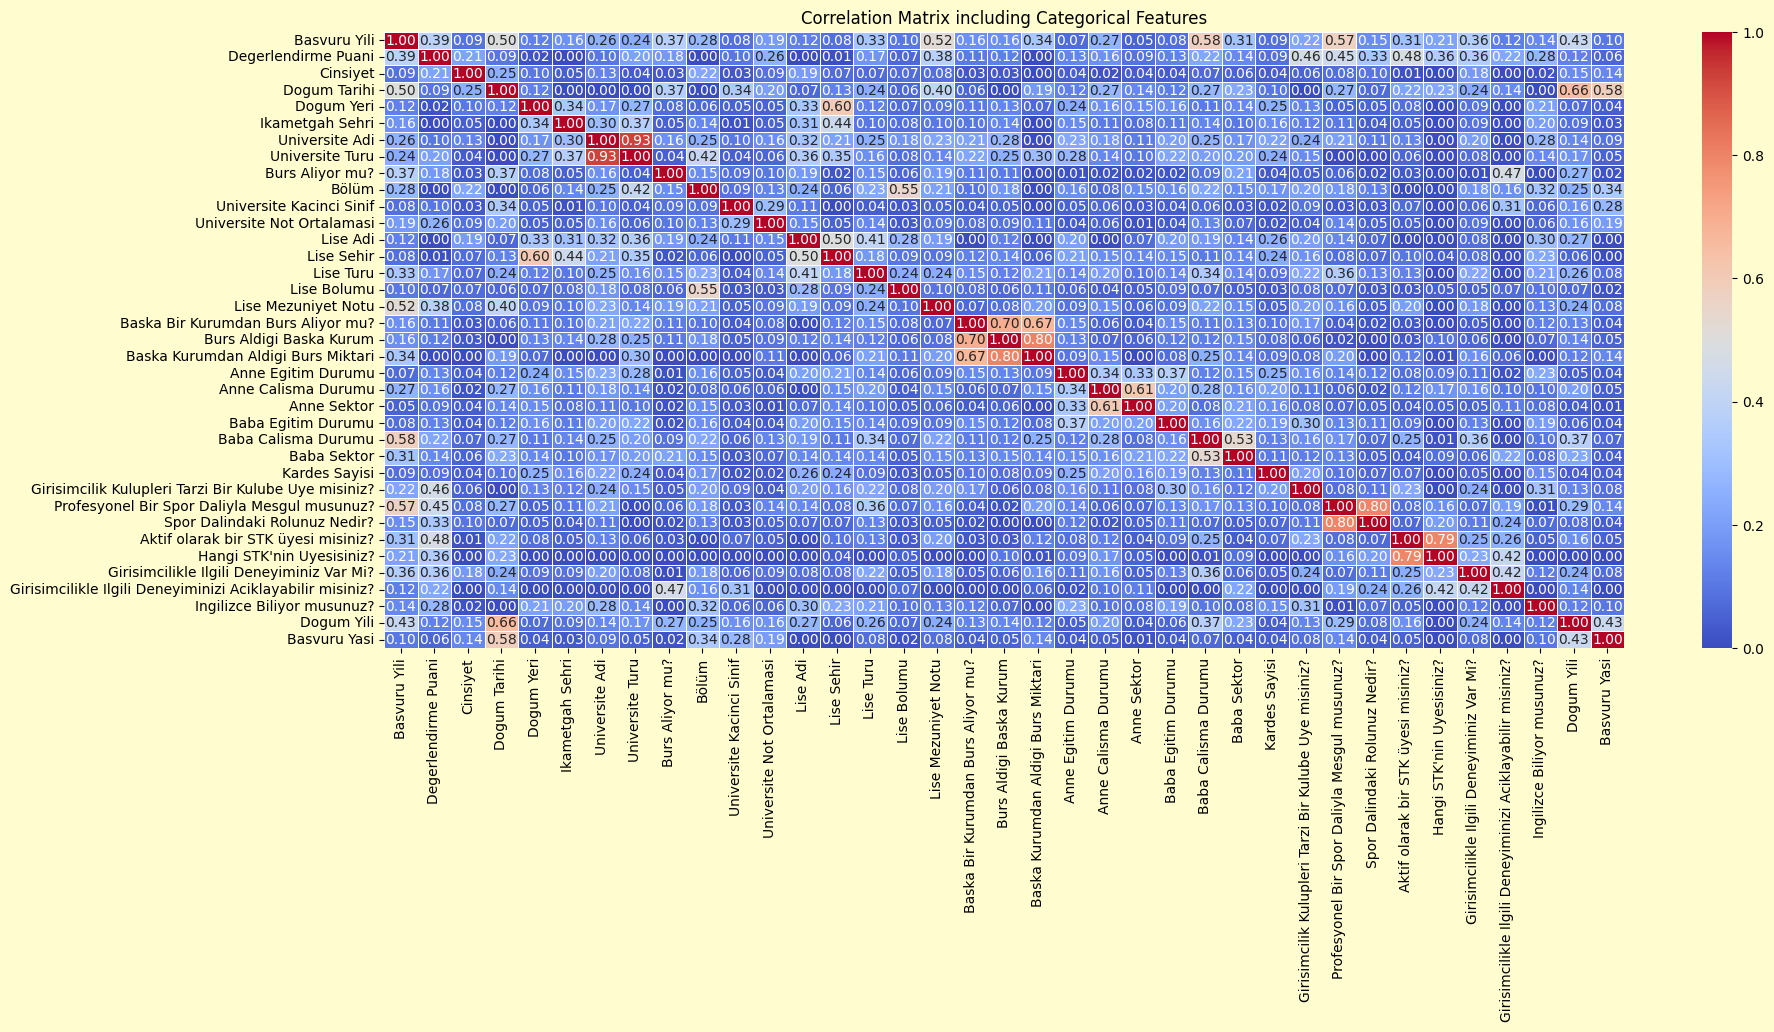

In [106]:
from dython.nominal import associations

associations_df = associations(train[:10000], nominal_columns='all', plot=False)
corr_matrix = associations_df['corr']
plt.figure(figsize=(20, 8))
plt.gcf().set_facecolor('#FFFDD0') 
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix including Categorical Features')
plt.show()
